# BERT: Fine-Tuning for Sentence Classification
* BERT Fine-Tuning Tutorial with PyTorch [Link](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX), [Link](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [YT Link 1](https://www.youtube.com/watch?v=x66kkDnbzi4), [YT Link 2](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fyoutu.be%2FHnvb9b7a_Ps)
* This BERT architecture only uses the encoder stack of
transformers.
*BERT's attention is in both directions (bidirectional) rather than predicting from left to right and masking future tokens. 
* BERT over comes the limitations of a traditional transformer model, especially if the masked sequnece contains meaning we're looking for.
* This model is fine tuned to succeed at a Acceptability Judgement downstream task. * Fine-tuning a pretrained model takes fewer machine resources than training downstream tasks from scratch.

In [1]:
#pip install tensorflow-gpu #Anything above 2.10 is not supported on the GPU on Windows Native
#python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))" #Verify install
#!pip install -q transformers

## Import Library

In [2]:
import tensorflow as tf

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences #from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, BertConfig, AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange #for progress bar ui
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

#Matthew's Correlation Coefficient for evaluation
from sklearn.metrics import matthews_corrcoef 

% matplotlib inline

d:\Projects\repos\ai\venv_nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
UsageError: Line magic function `%` not found.


### Specifying CUDA as the device for Torch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

### Check GPU available
#device = tf.test.gpu_device_name()
#if device != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device))
#https://stackoverflow.com/questions/66083545/could-not-load-dynamic-library-cudnn64-8-dll-dlerror-cudnn64-8-dll-not-found
#download the cudnn64_8.dll and put it in C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.x\bin
#then try python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

'NVIDIA GeForce GTX 1060'

## Import Dataset
Corpus of Linguistic Acceptability (CoLA) dataset from Warstadt et al. (2018) paper. General Language Understanding Evaluation (GLUE) considers Linguistic Acceptability to gauge transformer efficiency.

[Link to dataset](https://nyu-mll.github.io/CoLA/), each line in the .tsv files consists of 4 tab-separated columns:
* Column 1:	the code representing the source of the sentence.
* Column 2:	the acceptability judgment label (0=unacceptable, 1=acceptable).
* Column 3:	the acceptability judgment as originally notated by the author.
* Column 4:	the sentence.

In [5]:
#https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
df = pd.read_csv("data\in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [6]:
df.sample(10)

,sentence_source,label,label_notes,sentence
7692,sks13,1,NaN,I worked on Sunday in the city on that project...
3462,ks08,0,*,much clue is needed.
3839,ks08,1,NaN,Mary looked at the sky.
212,cj99,1,NaN,"The more people that you give beer to, the mor..."
7946,ad03,1,NaN,We donated a chopper to the new hospital
23,gj04,0,*,We yelled Harry hoarse.
4403,ks08,1,NaN,John will leave the party earlier.
2673,l-93,1,NaN,Nora sent books to children.
582,bc01,0,*,The cup filled the water high.
156,cj99,1,NaN,Mary listens to the Grateful Dead and she gets...


## Data Preprocessing

In [7]:
sentences = df.sentence.values #pull out sentences as X features
labels = df.label.values #pull out labels for y target

#add special characters for BERT (CLS and SEP tokens at begining and end of each sentence). CLS stands for classification. SEP is end of sentence
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

#create a BERT Pretrained Tokenizer (saves time than training from scratch)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) #pretrained tokenizer ref: https://huggingface.co/bert-base-uncased
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print (tokenized_texts[0]) #tokenize the first sentence.

['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [8]:
MAX_LEN = 128 #original paper used 512, our max sequence length is 42 so we choose 128 to leave space.
# Convert tokens to index numbers of BERT vocab
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
print(input_ids)
print("\n")
#pad the input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(input_ids)

[[101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 1998, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 2030, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 1996, 2062, 2057, 2817, 16025, 1010, 1996, 13675, 16103, 2121, 2027, 2131, 1012, 102], [101, 2154, 2011, 2154, 1996, 8866, 2024, 2893, 14163, 8024, 3771, 1012, 102], [101, 1045, 1005, 2222, 8081, 2017, 1037, 4392, 1012, 102], [101, 5965, 27129, 1996, 4264, 4257, 1012, 102], [101, 3021, 19055, 2010, 2126, 2041, 1997, 1996, 4825, 1012, 102], [101, 2057, 1005, 2128, 5613, 1996, 2305, 2185, 1012, 102], [101, 11458, 25756, 1996, 3384, 4257, 1012, 102], [101, 1996, 4401, 4191, 1996, 2377, 2125, 1996, 2754, 1012, 102], [101, 1996, 8644, 10619, 5024, 1012, 102], [101, 3021, 4565, 2041, 1997, 1996, 2282, 1012, 102], [101, 1996, 19785, 27129, 1996, 4870, 4257, 1012, 102], [101, 1996, 19785, 27129, 1996, 4870,

In [9]:
# Create attention masks
#we don't want the model to care about padding so we create a mask for it. (1 for mask, 0 for padding)
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [10]:
#Splitting data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
#training and validation masks
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

In [11]:
#move training and test set to GPU via torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [12]:
# Set batch size and data iterator
batch_size = 32 #author recommends 16 or 32

#we use torch DataLoader so as not to load all data into memory during training but at each iteration
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## BERT Model
This is the uncased configuration

In [13]:
#Configure BERT
configuration = BertConfig()
#initialise vert-base-uncased config
model = BertModel(configuration)
#check model config
configuration = model.config
print(configuration)

#- attention_probs_dropout_prob: 0.1 means 0.1 dropout ratio to the attention probabilities.
#- hidden_act: "gelu", a non-linear activation function in the encoder. Gaussian Error Linear Units activation function. Input is weighted by its magnitude, which makes it non-linear.
#- hidden_dropout_prob: 0.1 is the dropout probability applied to the fully connected layers. Full connections can be found in the embeddings, encoder, and pooler layers. 
# the pooler is there to convert the sequence tensor for classification tasks, 
# which require a fixed dimension to represent the sequence. The pooler will thus convert the sequence tensor to (batch size,
# hidden size), which are fixed parameters.
# hidden_size: 768 is the dimension of the encoded layers and also the pooler layer.
# initializer_range: 0.02 is the standard deviation value when initializing the weight matrices.
# intermediate_size: 3072 is the dimension of the feed-forward layer of the encoder.
# layer_norm_eps: 1e-12 is the epsilon value for layer normalization layers.
# max_position_embeddings: 512 is the maximum length the model uses.
# model_type: "bert" is the name of the model.
# num_attention_heads: 12 is the number of heads.
# num_hidden_layers: 12 is the number of layers.
# pad_token_id: 0 is the ID of the padding token to avoid training padding tokens.
# type_vocab_size: 2 is the size of the token_type_ids, which identify the sequences. For example, "the dog[SEP] The cat.[SEP]" can be represented with 6 token IDs: [0,0,0, 1,1,1].
# vocab_size: 30522 is the number of different tokens used by the model to represent the input_ids.


BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



### Transformer diagram
![Transformer Model](https://miro.medium.com/v2/resize:fit:856/1*ZCFSvkKtppgew3cc7BIaug.png)

In [14]:
#load a Bert Uncased Base Model from Hugging Face and move to GPU
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [15]:
#Optimizer Grouped Parameters
# Finetuning a model begins with initializing the pretrained model parameter values
## Bert only has bias terms, no gammer or beta parameters so we don't apply weight decay to any params that include these token names 
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [#optimizer_grouped_parameters` only includes the parameter values not names
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1}, # weight_decay_rate to avoid overfitting
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [16]:
epochs = 4 #author recommends between 2 and 4

#The Hyperparemeters for the Training Loop 
optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
#optimizer = BertAdam(optimizer_grouped_parameters,
#                     lr=2e-5,
#                     warmup=.1)
# Total number of training steps. We get number of batches from length of train_dataloader
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler. #num_warmup_steps = 0, # Default value in run_glue.py
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
#Some researchers argue that the gradients at the output level of the sub-layers before layer normalization do not require a warm-up rate

d:\Projects\repos\ai\venv_nlp\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
#Accuracy Measurement Function
## calculates the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Train BERT Model

In [18]:
#The Training Loop
t = []
train_loss_set = [] # accuracy/losses for plotting

#t-range is a tqdm wrapper around normal python range function epochs=4 
for _ in trange(epochs, desc='Epoch'): 
    model.train()#set to training mode (later we will put in validation mode)

    tr_loss, nb_tr_examples, nb_tr_steps = 0, 0, 0 #tracking variables
    
    #train data for one epoch
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch) #add batch to gpu
        b_input_ids, b_input_mask, b_labels = batch # unpack
        optimizer.zero_grad() #zero the gradients
        #forward pass
        outputs = model(b_input_ids, 
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs['loss']
        train_loss_set.append(loss.item())
        #back prop
        loss.backward()
        #update parames and step via computed gradient
        optimizer.step()

        #update learning rate
        scheduler.step()

        #update tracking vars
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Training loss: " + str(round(tr_loss/nb_tr_steps, 3)))

    #The Validation Loop
    model.eval() #now we put the model in validation mode

    #tracking variables
    eval_loss, eval_accuracy, nb_eval_steps, nb_eval_examples= 0, 0, 0, 0 

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch) #add batch to gpu
        b_input_ids, b_input_mask, b_labels = batch # unpack
        #do without computing gradients
        with torch.no_grad():
            #forward and calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        #move logits and labels to CPU
        logits = logits['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: " + str(round(eval_accuracy/nb_eval_steps, 3)))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.499


Epoch:  25%|██▌       | 1/4 [03:54<11:44, 234.96s/it]

Validation Accuracy: 0.798
Training loss: 0.303


Epoch:  50%|█████     | 2/4 [07:50<07:50, 235.11s/it]

Validation Accuracy: 0.831
Training loss: 0.177


Epoch:  75%|███████▌  | 3/4 [13:04<04:31, 271.34s/it]

Validation Accuracy: 0.829
Training loss: 0.111


Epoch: 100%|██████████| 4/4 [16:59<00:00, 254.96s/it]

Validation Accuracy: 0.835


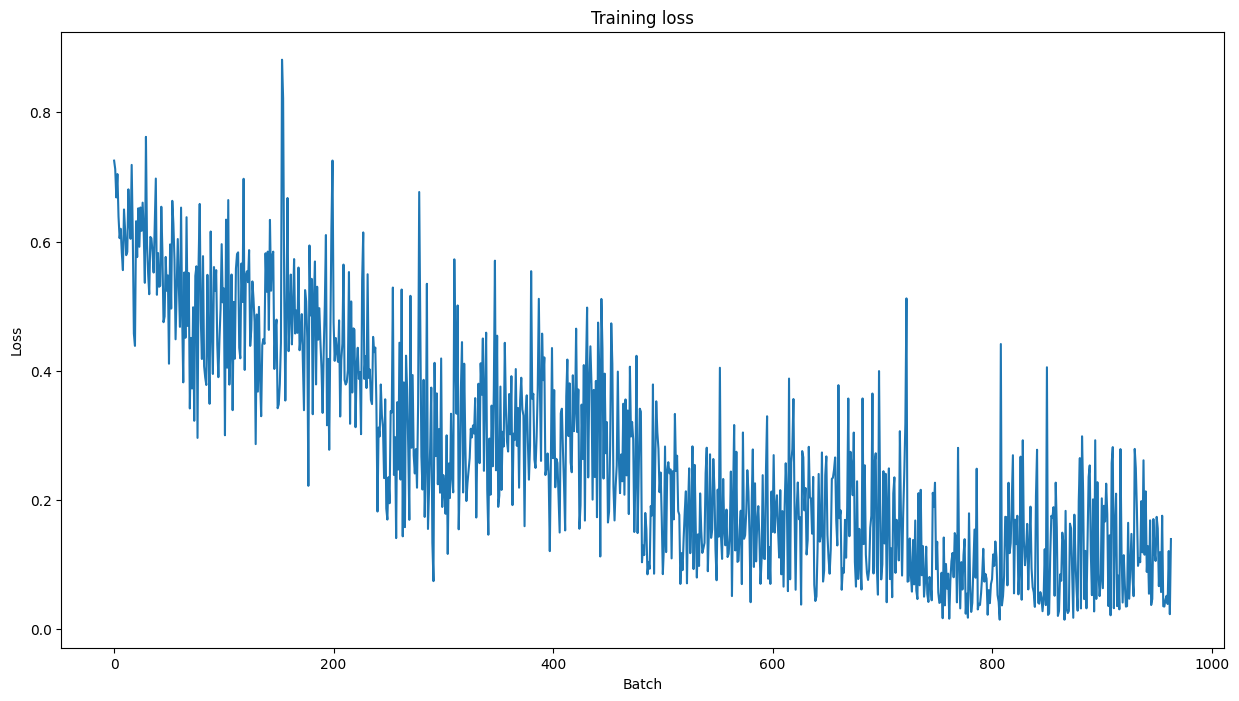

In [19]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Predict using BERT

In [20]:
df = pd.read_csv("data\out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

sentences = df.sentence.values

sentence=['[CLS]' + sentence + ' [SEP]' for sentence in sentences]
labels = df.label.values
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

MAX_LEN = 128

# convert tokens to their index number in BERT vocab
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
#pad input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [21]:
model.eval()#evaluation mode

predictions , true_labels = [], [] #Tracking variables 

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [22]:
#The value produced by MCC is between -1 and +1. +1 is the maximum positive 
#value of a prediction. 
#-1 is an inverse prediction. 
#0 is an average random prediction.
#GLUE evaluates Linguistic Acceptability with MCC.
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i], np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

print(matthews_set)#score for each batch
#Almost all the MCC values are positive, which is good

[0.5219786367558533, -0.050964719143762556, 0.06362847629757777, 0.17806849308658554, 0.2842974802836732, 0.47306844125299624, 0.034815531191139566, 0.060522753266880246, 0.3094922302950865, -0.020601266687222692, 0.2789579047098707, 0.061898446059017294, 0.47306844125299624, 0.23372319715296222, 0.19432508268938872, 0.15749883157896472, 0.0]


In [23]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matco = matthews_corrcoef(flat_true_labels, flat_predictions)
print(round(matco, 3))
#The output confirms that the MCC is positive, which shows that there is
# a correlation for this model and dataset

0.227
